In [1]:
import utils
from utils import *
import xgboost as xgb

%matplotlib inline


/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Helper classes 

### Load features

In [ ]:
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))

In [3]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))


In [37]:
abhishek_train = pd.read_csv(data_home+"abhishek_train_features.csv")
abhishek_test = pd.read_csv(data_home+"abhishek_test_features.csv")

In [63]:
abhishek_train = abhishek_train.ix[:,2:]

In [65]:
abhishek_test = abhishek_test.ix[:, 2:] 

In [71]:
abhishek_train.shape,abhishek_test.shape

((404290, 28), (2345796, 28))

#### Magic feature!

In [56]:
q_frequency_train = pd.read_csv("data/question_frequency_train.csv")
q_frequency_test = pd.read_csv("data/question_frequency_test.csv")


In [57]:
q_frequency_train.shape, q_frequency_test.shape

((404290, 6), (2345796, 5))

In [60]:
q_frequency_train  = q_frequency_train.ix[:,3:5]

In [62]:
q_frequency_test = q_frequency_test.ix[:,3:5]

In [70]:
q_frequency_train.shape, q_frequency_test.shape

((404290, 2), (2345796, 2))

#### Nostrov features

In [50]:
nostrov = pd.read_csv('data/nestrov_feats.csv')

In [51]:
ix_train = np.where(nostrov['id'] >= 0)[0]
ix_test = np.where(nostrov['id'] == -1)[0]

In [52]:
nostrov_diff = nostrov.ix[:,10:]

In [68]:
nostrov_train = nostrov_diff.iloc[ix_train]
nostrov_test = nostrov_diff.iloc[ix_test]

nostrov_train.shape, nostrov_test.shape

((404290, 28), (2345796, 28))

In [69]:
del nostrov, nostrov_diff

#### Add all together 

In [72]:
train_features = np.hstack((abhishek_train,q_frequency_train, nostrov_train))


In [74]:
test_features = np.hstack((abhishek_test,q_frequency_test, nostrov_test))


In [75]:
del abhishek_test, abhishek_train, q_frequency_train,q_frequency_test, nostrov_train, nostrov_test

In [76]:
save_array("data/cache/ab_qfreq_nostrov_train.dat", train_features)

In [77]:
save_array("data/cache/ab_qfreq_nostrov_test.dat", test_features)

In [2]:
train_features = load_array("data/cache/ab_qfreq_nostrov_train.dat")
test_features = load_array("data/cache/ab_qfreq_nostrov_test.dat")


In [9]:
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))

In [3]:
train_features.shape, test_features.shape

((404290, 58), (2345796, 58))

In [5]:
train_features = np.nan_to_num(train_features)
test_features = np.nan_to_num(test_features)

#### Weighting

In [7]:
np.random.seed(2189)

perm = np.random.permutation(len(train_features))
ix_fit = perm[:int(len(train_features)*(1-0.1))]
ix_valid = perm[int(len(train_features)*(1-0.1)):]

In [13]:
re_weight = True 

if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None
    
y_val = labels[ix_valid]
y_train = labels[ix_fit]

weight_val = np.ones(len(y_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[y_val==0] = 1.309028344    
    
    
    

weight_train = np.ones(len(y_train))
if re_weight:
    weight_train *= 0.472001959
    weight_train[y_train==0] = 1.309028344        

### Models 


#### XGBoost

In [ ]:
def set_weights(y_train,y_val):
    
    weight_train = np.ones(len(y_train))
    weight_train *= 0.472001959
    weight_train[y_train==0] = 1.309028344        
    
    
    weight_val = np.ones(len(y_val))
    weight_val *= 0.472001959
    weight_val[y_val==0] = 1.309028344    



    return weight_train, weight_val

In [54]:
skf = StratifiedKFold(n_splits=10, random_state=2019)
splits = skf.split(train_features, labels)


In [ ]:
xgb_models = []
y_test = []

for ix_fit, ix_valid in tqdm_notebook(splits, total=10):
    y_val = labels[ix_valid]
    y_train = labels[ix_fit]

    weight_train, weight_val = set_weights(y_train,y_val)
                                           
    d_train = xgb.DMatrix(train_features[ix_fit],label= y_train, weight=weight_train)
    d_valid = xgb.DMatrix(train_features[ix_valid],label= y_val,weight=weight_val)                                       
    
    y_test.append(model.predict_proba(train_features[ix_valid])[:, 1])
    xgb_models.append(model)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    bst = xgb.train(xgb_params, d_train, 1000,  watchlist, early_stopping_rounds=100, verbose_eval=10)
    
    xgb_models.append(bst)
    
    y_test.append(bst.predict(d_valid))


In [50]:







# '''

# 'scale_pos_weight': 1
# 'gamma': 0, 
# 'subsample': 0.75, 
# 'colsample_bytree': 0.75, 
# 'colsample_bylevel': 1,
# 'reg_alpha': 0, 
# 'reg_lambda': 1

# '''


In [62]:

xgb_params = {
'max_depth': 12, 
'learning_rate': 0.075,
'n_estimators': 1700, #2500
'objective': 'binary:logistic',
# 'nthread': 128, 
'eval_metric' :'logloss'

}

In [63]:
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(xgb_params, d_train, 1000,  watchlist, early_stopping_rounds=100, verbose_eval=10)


[0]	train-logloss:0.641456	valid-logloss:0.643031
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.367311	valid-logloss:0.381546
[20]	train-logloss:0.266804	valid-logloss:0.29074
[30]	train-logloss:0.221365	valid-logloss:0.253325
[40]	train-logloss:0.198627	valid-logloss:0.236452
[50]	train-logloss:0.185694	valid-logloss:0.228487
[60]	train-logloss:0.177858	valid-logloss:0.224052
[70]	train-logloss:0.17192	valid-logloss:0.221462
[80]	train-logloss:0.167365	valid-logloss:0.219975
[90]	train-logloss:0.163279	valid-logloss:0.218768
[100]	train-logloss:0.159252	valid-logloss:0.217824
[110]	train-logloss:0.156064	valid-logloss:0.217282
[120]	train-logloss:0.151827	valid-logloss:0.216806
[130]	train-logloss:0.148278	valid-logloss:0.216588
[140]	train-logloss:0.145446	valid-logloss:0.216244
[150]	train-logloss:0.141127	valid-logloss:0.216066
[160]	train-logloss:0.138043	

KeyboardInterrupt: 

In [ ]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()


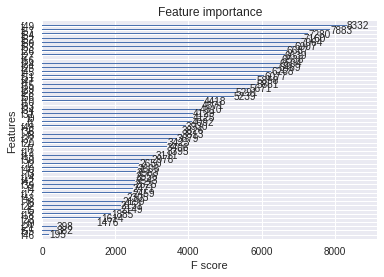

In [53]:

xgb.plot_importance(bst)

In [36]:
# make a collective

d_test = xgb.DMatrix(test_features)
p_test = bst.predict(d_test)

In [38]:
df_test = pd.read_csv(data_home+'test.csv')

sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p_test})
sub.head(2)

,is_duplicate,test_id
0,0.000085,0
1,0.486413,1


In [39]:
submission_name = "subm/xgb_all_features.csv"

sub.to_csv(path+submission_name, index=False)

In [40]:
FileLink(submission_name)

/home/ubuntu/quora/subm/xgb_all_features.csv

In [21]:
# for ix_fit, ix_valid in tqdm_notebook(splits, total=10):

model = xgb.XGBClassifier().set_params(**xgb_params)
xgb.train()
model = model.fit(x_train, 
                  eval_set=[(x_valid, y_val)], 
                  eval_metric="logloss",
                  early_stopping_rounds=20)

# y_test.append(model.predict_proba(train_features[ix_valid])[:, 1])
# xgb_models.append(model)


Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7fb9ab88ed90>> ignored


TypeError: can not initialize DMatrix from DMatrix

In [ ]:
y_test_pred = np.array(y_test).T.mean(axis=1)
y_test_pred_fixed = link_function(y_test_pred)

pd.DataFrame.from_records(
    zip(df.loc[ix_test]['test_id'].values, 
        y_test_pred_fixed), 
    columns=['test_id', 'is_duplicate']).to_csv('./../submits/25_pred_fixed.csv', index=False)